In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tqdm

# Organize metadata

In [2]:
meta = pd.read_csv("/raid/data/cellpainting/TAORF/inputs/metadata/index.csv")

In [3]:
ground_truth = pd.read_csv("/raid/data/cellpainting/TAORF/downstream/TAORF_MOA_MATCHES.csv")
ground_truth["Evaluated"] = True
meta = pd.merge(meta, ground_truth[["Var1", "Evaluated"]], left_on=["broad_sample"], right_on="Var1", how="left")

In [4]:
meta = meta.drop("pert_name_replicate", axis=1)
meta = meta.drop("val", axis=1)
meta = meta.drop("Var1", axis=1)

# Assignment of plates to training and validation
meta.loc[meta.Metadata_Plate == 41744, "Training_Status"] = "Training"
meta.loc[meta.Metadata_Plate == 41754, "Training_Status"] = "Training"
meta.loc[meta.Metadata_Plate == 41755, "Training_Status"] = "Training"
meta.loc[meta.Metadata_Plate == 41756, "Training_Status"] = "Validation"
meta.loc[meta.Metadata_Plate == 41757, "Training_Status"] = "Validation"

In [5]:
# Perturbations that will not be used for training
blocklist = list(meta[meta.pert_name.str.contains("mismatch")].groupby("pert_name").count().reset_index().pert_name)
blocklist += list(meta[meta.pert_name.str.contains("trunc")].groupby("pert_name").count().reset_index().pert_name)
blocklist += list(meta[meta.pert_name.str.contains("CTRL")].groupby("pert_name").count().reset_index().pert_name)

# Unique number of perturbations
len(meta[~meta.pert_name.isin(blocklist)].pert_name.unique())

311

In [6]:
meta.loc[meta.pert_name.isin(blocklist), "Training_Status"] = "Unused"
meta.groupby(["Metadata_Plate", "Training_Status"]).count()

Metadata_Well  Metadata_Site  \
Metadata_Plate Training_Status                                 
41744          Training                  3089           3089   
               Unused                     342            342   
41754          Training                  3102           3102   
               Unused                     341            341   
41755          Training                  3113           3113   
               Unused                     342            342   
41756          Unused                     342            342   
               Validation                3110           3110   
41757          Unused                     341            341   
               Validation                3105           3105   

                                Assay_Plate_Barcode  Plate_Map_Name   DNA  \
Metadata_Plate Training_Status                                              
41744          Training                        3089            3089  3089   
               Unused                           342             342   342   
41754          Training                        3102            3102  3102   
               Unused                           341             341   341   
41755          Training                        3113            3113  3113   
               Unused                           342             342   342   
41756          Unused                           342             342   342   
               Validation                      3110            3110  3110   
41757          Unused                           341             341   341   
               Validation                      3105            3105  3105   

                                 RNA    ER   AGP  Mito  gene_name  pert_name  \
Metadata_Plate Training_Status                                                 
41744          Training         3089  3089  3089  3089       3089       3089   
               Unused            342   342   342   342        342        342   
41754          Training         3102  3102  3102  3102       3102       3102   
               Unused            341   341   341   341        341        341   
41755          Training         3113  3113  3113  3113       3113       3113   
               Unused            342   342   342   342        342        342   
41756          Unused            342   342   342   342        342        342   
               Validation       3110  3110  3110  3110       3110       3110   
41757          Unused            341   341   341   341        341        341   
               Validation       3105  3105  3105  3105       3105       3105   

                                broad_sample  cell_line  ASSAY_WELL_ROLE  \
Metadata_Plate Training_Status                                             
41744          Training                 2774       3089             3089   
               Unused                    126        342              342   
41754          Training                 2787       3102             3102   
               Unused                    126        341              341   
41755          Training                 2798       3113             3113   
               Unused                    126        342              342   
41756          Unused                    126        342              342   
               Validation               2795       3110             3110   
41757          Unused                    125        341              341   
               Validation               2791       3105             3105   

                                GeneID  plate_map_name  Evaluated  
Metadata_Plate Training_Status                                     
41744          Training           2774            3089       1833  
               Unused              126             342          0  
41754          Training           2787            3102       1849  
               Unused              126             341          0  
41755          Training           2798            3113  

# Label single cells

In [7]:
sc_idx = pd.read_csv("/raid/data/cellpainting/TAORF/outputs/all_single_cells/sc-metadata.csv")

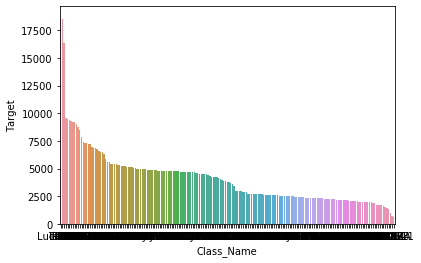

In [8]:
# Distribution of classes before sampling
sc_counts = sc_idx.groupby("Class_Name").count().reset_index()
sc_counts = sc_counts.sort_values("Target", ascending=False)
sb.barplot(data=sc_counts[sc_counts["Class_Name"] != "EMPTY"], x="Class_Name", y="Target")

In [9]:
sc_idx["Metadata_Plate"] = sc_idx.Key.str.split("/", expand=True)[0].astype(int)
sc_idx["Metadata_Well"] = sc_idx.Key.str.split("/", expand=True)[1]
sc_idx["Metadata_Site"] = sc_idx.Metadata_Well.str.split("-", expand=True)[1].astype(int)
sc_idx["Metadata_Well"] = sc_idx.Metadata_Well.str.split("-", expand=True)[0]

In [10]:
sc_expanded = pd.merge(sc_idx, meta, on=["Metadata_Plate", "Metadata_Well", "Metadata_Site"], how="left")

In [11]:
# Sampling function

def label_single_cells(sc_expanded, gene_names, status, budget, new_label):
    for gene in tqdm.tqdm(gene_names):
        f1 = sc_expanded.gene_name == gene
        f2 = sc_expanded.Training_Status == status
        sites = sc_expanded[f1 & f2].groupby(["pert_name", "Metadata_Plate", "Metadata_Well", "Metadata_Site"]).count().reset_index()
        available_cells = sites["Key"].sum()

        if available_cells > budget:
            num_samples = int(np.ceil(budget / len(sites)))
            for k,r in sites.iterrows():
                sample = sc_expanded.query(
                    f"pert_name == '{r.pert_name}' & Metadata_Plate == '{r.Metadata_Plate}' & Metadata_Well == '{r.Metadata_Well}' & Metadata_Site == '{r.Metadata_Site}'"
                )
                if len(sample) >= num_samples:
                    sample = sample.sample(n=num_samples)
                sc_expanded.loc[sample.index, "Training_Status"] = new_label
        else:
            sc_expanded.loc[f1 & f2, "Training_Status"] = new_label

        f3 = sc_expanded.Training_Status == new_label

In [12]:
# Sampling single cells for training
gene_names = sc_expanded[sc_expanded.Evaluated == True].gene_name.unique()
label_single_cells(sc_expanded, gene_names, "Training", 1100, "SingleCellTraining")
label_single_cells(sc_expanded, ["EMPTY"], "Training", 1100, "SingleCellTraining")

100%|██████████| 1/1 [01:32<00:00, 92.25s/it]


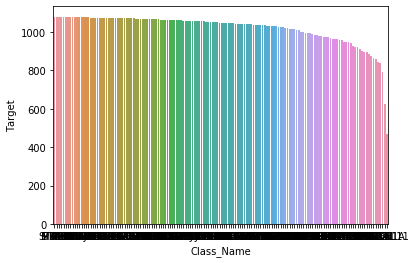

In [13]:
# Distribution of classes in the training set
sc_counts = sc_expanded[sc_expanded.Training_Status == "SingleCellTraining"].groupby("Class_Name").count().reset_index()
sc_counts = sc_counts.sort_values("Target", ascending=False)
sb.barplot(data=sc_counts[sc_counts["Class_Name"] != "EMPTY"], x="Class_Name", y="Target")

In [14]:
print("Training cells:", len(sc_expanded[sc_expanded.Training_Status == "SingleCellTraining"]))

Training cells: 152084


In [15]:
# Sampling single cells for validation
label_single_cells(sc_expanded, gene_names, "Validation", 150, "SingleCellValidation")
label_single_cells(sc_expanded, ["EMPTY"], "Validation", 150, "SingleCellValidation")

100%|██████████| 1/1 [01:03<00:00, 63.22s/it]


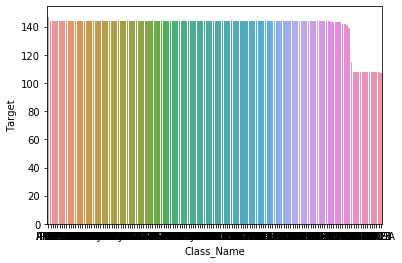

In [16]:
# Distribution of classes in the validation set
sc_counts = sc_expanded[sc_expanded.Training_Status == "SingleCellValidation"].groupby("Class_Name").count().reset_index()
sc_counts = sc_counts.sort_values("Target", ascending=False)
sb.barplot(data=sc_counts[sc_counts["Class_Name"] != "EMPTY"], x="Class_Name", y="Target")

In [17]:
print("Validation cells:", len(sc_expanded[sc_expanded.Training_Status == "SingleCellValidation"]))

Training cells: 20800


In [19]:
# Save the resulting file to disk
sc_expanded.to_csv("/raid/data/cellpainting/TAORF/outputs/expanded_sc_metadata.csv", index=False)